In [1]:
### Author: Leonie Küchenhoff
### Date: October 2022
### Purpose of script: Script to check list of variats in more detail.
###             The following things will be checked:
###
###             1. Is it an A>G mutation?
###             2. Are there any gRNA Sequence similarities in proximity?


In [1]:
import numpy as np
import pandas as pd
import os
from Bio import SeqIO
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
from config import outdir, tissue_specdir, reference_seq

In [2]:
# filter variable will be used as info to save plots
filter = '1ed'
helper_scripts = str(os.getcwd())
#base directory
basedir = tissue_specdir
outdir = str(outdir + '/variant_surrounding/')
print('This base directory will be used:\n', basedir)    
os.chdir(basedir)

#path to refernce sequence
ref_seq = reference_seq

#gRNA + PAM sequence 
grna = 'GAACGTAGCCGCTCTGGACCANRN'

#sample names
names = ['279', '282', '450']

This base directory will be used:
 /g/steinmetz/project/leonie_crispr/03_data/01_heartproject/snakemake_vcf/tissue_spec_vars


FileNotFoundError: [Errno 2] No such file or directory: '/g/steinmetz/project/leonie_crispr/03_data/01_heartproject/snakemake_vcf/tissue_spec_vars'

In [3]:
# read in reference sequence
def read_reference_data(path_ref):
    reference = SeqIO.to_dict(SeqIO.parse(ref_seq, 'fasta'))
    return reference

In [8]:
reference  = read_reference_data(ref_seq)

In [11]:
# Read in list of tissue specific variants to find location of variants
heart_spec_dict = {}
for i in names:
    heart_spec_dict[i] = pd.read_csv(f'/sample_{i}_{filter}.txt', delimiter='\t')

tail_spec_dict = {}
for i in names:
    tail_spec_dict[i] = pd.read_csv(f'/tail_sample_{i}_{filter}.txt', delimiter='\t')

liver_spec_dict = {}
for i in names:
    liver_spec_dict[i] = pd.read_csv(f'/liver_sample_{i}_{filter}.txt', delimiter='\t')

In [25]:
chromosomes = ['chr1',
                'chr2',
                'chr3',
                'chr4',
                'chr5',
                'chr6',
                'chr7',
                'chr8',
                'chr9',
                'chr10',
                'chr11',
                'chr12',
                'chr13',
                'chr14',
                'chr15',
                'chr16',
                'chr17',
                'chr18',
                'chr19',
                'chrX',
                'chrY']

In [32]:
def save_refseq(position_dict, tissue, names):
    '''
    function to interate through positions of varaints and save reference sequence +/- 30 bases in table
    '''
    seq_dict = {}
    for name in names:
        seq_list = []
        for chr in chromosomes:
            seq = reference[chr].upper()
            positions = position_dict[name][position_dict[name]['chr'] == chr]['pos'].to_list()
            for i in positions:
                seq_pos = seq[i-30: i + 30]
                seq_list.append(str(seq_pos.seq))
        seq_dict[name] = seq_list
        pd.DataFrame({'gRNA':grna, 'genome_dna':seq_dict[name]}).to_csv(f'heart_specific_variants/density_filter/{tissue}_genomic_surrounding_sample_{name}_{filter}.txt', sep = '\t', index = False)


In [33]:
save_refseq(heart_spec_dict, 'heart', names)
save_refseq(liver_spec_dict, 'liver', names)
save_refseq(tail_spec_dict, 'tail', names)

In [36]:
# costum perl script to align PAM sequence & gRNA to region around variant and output number of mismatches to best match in region
os.system(f'''
perl {helper_scripts}/semi_global_alignment.pl -in heart_genomic_surrounding_sample_279_1ed.txt -o heart_genomic_surrounding_sample_279_analysis_1ed.txt &&
perl {helper_scripts}/semi_global_alignment.pl -in heart_genomic_surrounding_sample_282_1ed.txt -o heart_genomic_surrounding_sample_282_analysis_1ed.txt &&
perl {helper_scripts}/semi_global_alignment.pl -in heart_genomic_surrounding_sample_450_1ed.txt -o heart_genomic_surrounding_sample_450_analysis_1ed.txt &&
perl {helper_scripts}/semi_global_alignment.pl -in tail_genomic_surrounding_sample_279_1ed.txt -o tail_genomic_surrounding_sample_279_analysis_1ed.txt &&
perl {helper_scripts}/semi_global_alignment.pl -in tail_genomic_surrounding_sample_282_1ed.txt -o tail_genomic_surrounding_sample_282_analysis_1ed.txt &&
perl {helper_scripts}/semi_global_alignment.pl -in tail_genomic_surrounding_sample_450_1ed.txt -o tail_genomic_surrounding_sample_450_analysis_1ed.txt &&
perl {helper_scripts}/semi_global_alignment.pl -in liver_genomic_surrounding_sample_279_1ed.txt -o liver_genomic_surrounding_sample_279_analysis_1ed.txt &&
perl {helper_scripts}/semi_global_alignment.pl -in liver_genomic_surrounding_sample_282_1ed.txt -o liver_genomic_surrounding_sample_282_analysis_1ed.txt &&
perl {helper_scripts}/semi_global_alignment.pl -in liver_genomic_surrounding_sample_450_1ed.txt -o liver_genomic_surrounding_sample_450_analysis_1ed.txt''')


Can't locate Bio/SeqIO.pm in @INC (you may need to install the Bio::SeqIO module) (@INC contains: /home/kuechenh/anaconda3/lib/perl5/5.32/site_perl /home/kuechenh/anaconda3/lib/perl5/site_perl /home/kuechenh/anaconda3/lib/perl5/5.32/vendor_perl /home/kuechenh/anaconda3/lib/perl5/vendor_perl /home/kuechenh/anaconda3/lib/perl5/5.32/core_perl /home/kuechenh/anaconda3/lib/perl5/core_perl .) at /g/steinmetz/project/leonie_crispr/02_repo/00_externalcode/01_fromShengdi/semi_global_alignment/semi_global_alignment.pl line 6.
BEGIN failed--compilation aborted at /g/steinmetz/project/leonie_crispr/02_repo/00_externalcode/01_fromShengdi/semi_global_alignment/semi_global_alignment.pl line 6.


512

In [10]:
# read in results from perl script

analysed_heart = pd.DataFrame()
for i in names:
    analysed_sample = pd.read_csv(f'heart_genomic_surrounding_sample_{i}_analysis_{filter}.txt',
                                        delimiter = '\t')
    analysed_sample['sample'] = i
    analysed_sample['tissue'] ='heart'
    analysed_heart = pd.concat([analysed_heart, analysed_sample])

analysed_liver = pd.DataFrame()
for i in names:
    analysed_sample = pd.read_csv(f'liver_genomic_surrounding_sample_{i}_analysis_{filter}.txt',
                                        delimiter = '\t')
    analysed_sample['sample'] = i
    analysed_sample['tissue'] ='liver'
    analysed_liver = pd.concat([analysed_liver, analysed_sample])

analysed_tail = pd.DataFrame()
for i in names:
    analysed_sample = pd.read_csv(f'tail_genomic_surrounding_sample_{i}_analysis_{filter}.txt',
                                        delimiter = '\t')
    analysed_sample['sample'] = i
    analysed_sample['tissue'] ='tail'
    analysed_tail = pd.concat([analysed_tail, analysed_sample])

In [11]:
# concatenate tables for easy plotting
mismatch_plot = pd.concat(
    [analysed_heart[['mismtaches', 'sample', 'tissue']],
    analysed_liver[['mismtaches', 'sample', 'tissue']],
    analysed_tail[['mismtaches', 'sample', 'tissue']]], 
    ignore_index = True
    )

In [13]:
# color & plot settings
colors = [sns.color_palette('colorblind')[3],
          sns.color_palette('colorblind')[2],
          sns.color_palette('colorblind')[1],
          sns.color_palette('colorblind')[0],
          'white',
          sns.color_palette('colorblind')[4],
          sns.color_palette('colorblind')[5],
          sns.color_palette('colorblind')[6],
          sns.color_palette('colorblind')[7],
          sns.color_palette('colorblind')[8]
          ]
costum_palette = sns.color_palette(colors)
plt.rcParams.update({'font.size':18, 'text.usetex': False,
"svg.fonttype": 'none'})

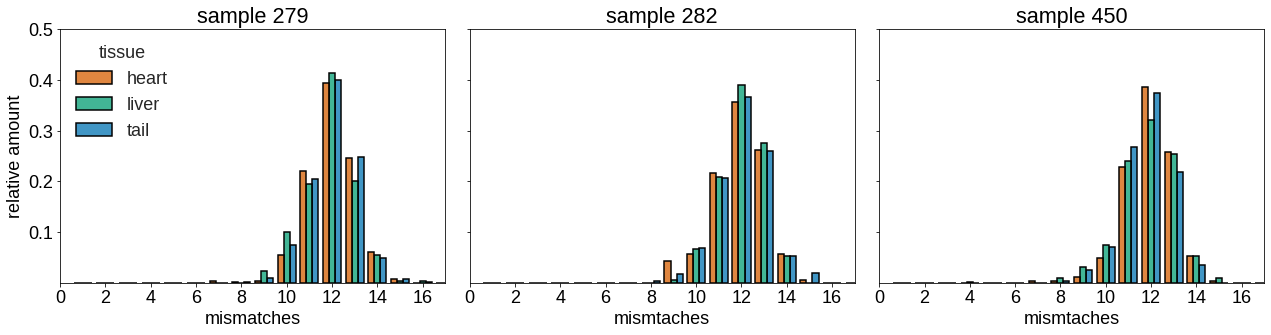

In [15]:
# plot samples separately

fig, ax = plt.subplots(1,3, figsize = (18,5), sharey = True, sharex = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
legend_elements = [Patch(facecolor=sns.color_palette('colorblind')[1],label='sample 279',edgecolor = 'black', linewidth = 2),
                    Patch(facecolor=sns.color_palette('colorblind')[2],label='sample 282', edgecolor = 'black', linewidth = 2),
                    Patch(facecolor=sns.color_palette('colorblind')[0],label='sample 450', edgecolor = 'black', linewidth = 2)]

sns.histplot(data = mismatch_plot[mismatch_plot['sample'] == '279'], x = 'mismtaches',hue= 'tissue', 
                stat = 'probability', ax = ax[0], binwidth = 1, binrange = (0.5,20.5),multiple = 'dodge', common_norm =False, 
                palette = [costum_palette[i] for i in [0,1,3]],edgecolor = 'black', linewidth = 1.5, shrink = 0.8, alpha=1)
sns.histplot(data = mismatch_plot[mismatch_plot['sample'] == '282'], x = 'mismtaches',hue= 'tissue', 
                stat = 'probability', ax = ax[1], binwidth = 1, binrange = (0.5,20.5), multiple = 'dodge', common_norm =False, 
                palette = [costum_palette[i] for i in [0,1,3]],edgecolor = 'black', linewidth = 1.5, shrink = 0.8, alpha=1)
sns.histplot(data = mismatch_plot[mismatch_plot['sample'] == '450'], x = 'mismtaches',hue= 'tissue', 
                stat = 'probability', ax = ax[2], binwidth = 1, binrange = (0.5,20.5), multiple = 'dodge', common_norm =False, 
                palette = [costum_palette[i] for i in [0,1,3]],edgecolor = 'black', linewidth = 1.5, shrink = 0.8, alpha=1)
ax[0].set_xlabel('mismatches')
ax[0].set_xlim(0,17)
ax[0].set_ylim(0.001,0.5)
ax[0].set_ylabel('relative amount')
ax[2].get_legend().remove()
ax[1].get_legend().remove()

ax[0].xaxis.set_major_locator(MaxNLocator(integer=False, ))

ax[0].set_title('sample 279')
ax[1].set_title('sample 282')
ax[2].set_title('sample 450')
fig.tight_layout()
plt.show()
#fig.savefig(f'{outdir}/tissue_spec_mismatches_{filter}.pdf', bbox_inches = 'tight')
#fig.savefig(f'{outdir}/tissue_spec_mismatches_{filter}.svg', bbox_inches = 'tight')

In [17]:
plt.rcParams.update({'font.size':20, 'text.usetex': False,
"svg.fonttype": 'none'})

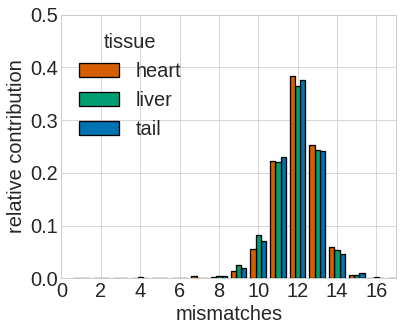

In [18]:
# plot samples together
fig, ax = plt.subplots(1, figsize = (6,5), sharey = True, sharex = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.histplot(data = mismatch_plot, x = 'mismtaches',hue= 'tissue', 
                stat = 'probability', ax = ax, binwidth = 1, binrange = (0.5,20.5),multiple = 'dodge', common_norm =False, 
                palette = [costum_palette[i] for i in [0,1,3]],edgecolor = 'black', linewidth = 1.3, shrink = 0.8, alpha=1)
                
ax.set_xlabel('mismatches')
ax.set_xlim(0,17)
ax.set_ylim(0,0.5)
ax.set_ylabel('relative contribution')

ax.xaxis.set_major_locator(MaxNLocator(integer=False, ))
fig.tight_layout()
plt.show()

# svae table and plots

#fig.savefig(f'{outdir}/tissue_spec_mismatches_{filter}_summed.pdf', bbox_inches = 'tight')
#mismatch_plot.rename(columns = {'mismtaches' : 'mismatches'}).to_csv(f'{outdir}/mismatches_tissue_spec_variants.csv', index = False)